## Import Libraries:

In [1]:
import warnings
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import os  # For interacting with the operating system
import matplotlib.pyplot as plt  # For plotting graphs
from sklearn.model_selection import ParameterGrid  # For generating parameter grid for hyperparameter tuning
from sklearn.metrics import log_loss  # For calculating log loss metric

# Suppress specific UserWarnings from the 'openpyxl' module to prevent cluttering the output
warnings.filterwarnings("ignore", category=UserWarning, module='openpyxl')## Load the data:

## Load the data:

In [2]:
# Define the directory where your files are located
# data_dir = '.'  
data_dir = os.path.join(os.path.pardir) 

# List to hold the dataframes
dataframes = []

# Loop through the years and load the files
for year in range(2005, 2020):
    if year <= 2012:
        file_path = os.path.join(data_dir, f'{year}.xls')
    else:
        file_path = os.path.join(data_dir, f'{year}.xlsx')
    
    # Load the file into a dataframe
    df = pd.read_excel(file_path)
    
    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all the dataframes into one
betting_data = pd.concat(dataframes, ignore_index=True)## Load the data:

## Fixing Anomalies

In [3]:
def is_column_numeric(df, column_name):
    # Check if the column contains only numeric values
    return df[column_name].apply(lambda x: str(x).isnumeric()).all()

In [4]:
# Check if columns are numeric before converting
anomaly_column = ['WRank', 'LRank', 'EXW']
for column in anomaly_column:
    if is_column_numeric(betting_data, column):
        print(f"Column '{column}' is numeric.\n")
    else:
        print(f"Column '{column}' is not numeric.\n")

Column 'WRank' is not numeric.

Column 'LRank' is not numeric.

Column 'EXW' is not numeric.



In [5]:
def find_non_numeric_values(df, column_name):
    # Function to check if a value is numeric
    def is_numeric(value):
        try:
            float(value)
            return True
        except ValueError:
            return False

    # Apply the function to the column and filter non-numeric values
    non_numeric_values = df[~df[column_name].apply(is_numeric)]

    # Display the non-numeric values
    print(f"Non-numeric values in {column_name}:")
    print(non_numeric_values[[column_name]])
    print()

In [6]:
# WRank column
find_non_numeric_values(betting_data, 'Wsets')

Non-numeric values in Wsets:
Empty DataFrame
Columns: [Wsets]
Index: []



In [7]:
# LRank column
find_non_numeric_values(betting_data, 'LRank')

Non-numeric values in LRank:
Empty DataFrame
Columns: [LRank]
Index: []



In [8]:
# EXW column
find_non_numeric_values(betting_data, 'EXW')

Non-numeric values in EXW:
        EXW
23776  2.,3



In [9]:
# Convert WRank and LRank to numeric, coercing errors
betting_data['WRank'] = pd.to_numeric(betting_data['WRank'], errors='coerce')
betting_data['LRank'] = pd.to_numeric(betting_data['LRank'], errors='coerce')

# Fill NaN values with a high number
betting_data['WRank'].fillna(100000, inplace=True)
betting_data['LRank'].fillna(100000, inplace=True)


# Correct the typo in row 38294, column 'EXW'
if betting_data.at[38294, 'EXW'] == '2.,3':
    betting_data.at[38294, 'EXW'] = '2.3'

## Preprocess Dataset:

In [10]:
# Create a new column 'higher_rank_won' to indicate if the higher-ranked player won the match
betting_data['higher_rank_won'] = (betting_data['WRank'] < betting_data['LRank']).astype(int)

# Calculate the points for the higher-ranked player:
# If the higher-ranked player won, use their points ('WPts');
# Otherwise, use the opponent's points ('LPts')
betting_data['higher_rank_points'] = (
    betting_data['higher_rank_won'] * betting_data['WPts'] + 
    betting_data['LPts'] * (1 - betting_data['higher_rank_won'])
)

# Calculate the points for the lower-ranked player:
# If the higher-ranked player lost, use their points ('WPts');
# Otherwise, use the opponent's points ('LPts')
betting_data['lower_rank_points'] = (
    (1 - betting_data['higher_rank_won']) * betting_data['WPts'] + 
    betting_data['LPts'] * betting_data['higher_rank_won']
)

# Fill any missing values in 'higher_rank_points' with 0 to avoid issues in further calculations
betting_data['higher_rank_points'].fillna(0, inplace=True)

# Fill any missing values in 'lower_rank_points' with 0 to ensure consistency in the dataset
betting_data['lower_rank_points'].fillna(0, inplace=True)

# Calculate the difference in sets won between the winner and the loser
betting_data['sets_difference'] = betting_data['Wsets'] - betting_data['Lsets']

# Filter the DataFrame to include only rows where the match status is 'Completed'
# This ensures that only fully played matches are considered in the analysis
betting_data = betting_data.loc[betting_data['Comment'] == 'Completed']

# Fill missing values in 'sets_difference' with the mean of the column
mean_value = betting_data['sets_difference'].mean()
betting_data['sets_difference'].fillna(mean_value, inplace=True)

# Create a copy of the betting_data DataFrame, named 'all_matches_k', for further processing
all_matches_k = betting_data.copy()

# List of columns to drop from the dataset as they are not needed for the analysis
columns_to_drop = [
    'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets', 'Comment',
    'CBW', 'CBL', 'IWW', 'IWL', 'B365W', 'B365L', 
    'EXW', 'EXL', 'PSW', 'PSL', 'WPts', 'LPts', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL',
    'MaxW', 'MaxL', 'AvgW', 'AvgL'
]

# Drop the unnecessary columns from 'all_matches_k' to simplify the dataset for analysis
all_matches_k = all_matches_k.drop(columns=columns_to_drop)

## Linear MOV model:

## Function Definitions and Setup:

In [11]:
def win_probability(E_i, E_j):
    """
    Calculate the probability of Player i winning against Player j based on their ratings.

    Parameters:
    E_i (float): The rating of Player i.
    E_j (float): The rating of Player j.

    Returns:
    float: The probability of Player i winning.
    """
    # Calculate and return the win probability using the Elo rating formula
    return 1 / (1 + 10 ** ((E_j - E_i) / 400))

In [12]:
def get_player_elo(player_name):
    """
    Retrieve the Elo rating of a player. If the player is not in the Elo dictionary,
    assign them an initial Elo rating.

    Parameters:
    player_name (str): The name of the player.

    Returns:
    float: The Elo rating of the player.
    """
    if player_name not in players_elo:
        players_elo[player_name] = initial_elo
    return players_elo[player_name]

In [13]:
def set_player_elo(player_name, elo):
    """
    Set the Elo rating for a specific player.

    Parameters:
    player_name (str): The name of the player.
    elo (float): The new Elo rating to be assigned to the player.
    """
    players_elo[player_name] = elo

In [14]:
def expected_margin(E_i, E_j, sigma):
    """
    Calculate the expected margin of victory based on the Elo ratings of two players.

    Parameters:
    E_i (float): The Elo rating of Player i.
    E_j (float): The Elo rating of Player j.
    sigma (float): The scaling parameter that controls the spread of expected margins.

    Returns:
    float: The expected margin of victory for Player i over Player j.
    """
    return (E_i - E_j) / sigma

In [15]:
def update_elo_mov(E_i, E_j, K, actual_margin, sigma):
    """
    Update the Elo rating for a player based on the match's margin of victory.

    Parameters:
    E_i (float): The current Elo rating of player i.
    E_j (float): The Elo rating of the opponent, player j.
    K (float): The K-factor, which determines how much the Elo rating changes after a match.
    actual_margin (int): The actual margin of victory (e.g., difference in sets won).
    sigma (float): The scaling parameter for the expected margin.

    Returns:
    float: The updated Elo rating of player i.
    """
    expected_m = expected_margin(E_i, E_j, sigma)
    delta_E_i = K * (actual_margin - expected_m)
    return E_i + delta_E_i

In [16]:
def update_elo_and_probabilities_mov(df, K, sigma):
    """
    Update the Elo ratings and win probabilities for each match in the dataset based on the MOV model.

    Parameters:
    df (pandas.DataFrame): DataFrame containing match data. Expected columns:
                           - 'Winner': Name of the player who won the match.
                           - 'Loser': Name of the player who lost the match.
                           - 'sets_difference': The margin of victory in sets (e.g., 2-0 -> 2).
    K (float): The K-factor, which determines how much the Elo rating changes after a match.
    sigma (float): The scaling parameter for the expected margin.

    Returns:
    None: The DataFrame is modified in place with updated Elo ratings and probabilities.
    """
    for index, match in df.iterrows():
        winner_name, loser_name = match['Winner'], match['Loser']
        margin_of_victory = match['sets_difference']

        # Retrieve current Elo ratings
        winner_elo = get_player_elo(winner_name)
        loser_elo = get_player_elo(loser_name)
        
        # Calculate win probabilities
        df.at[index, 'prob_winner'] = win_probability(winner_elo, loser_elo)
        
        # Determine match outcomes based on probability and who was expected to win
        if match['higher_rank_won']:
            df.at[index, 'match_outcome'] = int(df.at[index, 'prob_winner'] > 0.5)
            df.at[index, 'prob_high_ranked'] = df.at[index, 'prob_winner']
        else:
            df.at[index, 'match_outcome'] = int((1 - df.at[index, 'prob_winner']) > 0.5)
            df.at[index, 'prob_high_ranked'] = 1 - df.at[index, 'prob_winner']

        # Update Elo ratings based on MOV
        new_winner_elo = update_elo_mov(winner_elo, loser_elo, K, margin_of_victory, sigma)
        new_loser_elo = update_elo_mov(loser_elo, winner_elo, K, -margin_of_victory, sigma)  # Negative margin for the loser
        
        # Set the updated Elo ratings
        set_player_elo(winner_name, new_winner_elo)
        set_player_elo(loser_name, new_loser_elo)

In [17]:
def evaluate_mov_model(df):
    """
    Evaluate the performance of the Linear MOV model by calculating log loss, accuracy, and calibration.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the actual outcomes and predicted probabilities.
                           Expected columns:
                           - 'higher_rank_won': Actual outcome (1 if higher-ranked player won, 0 otherwise).
                           - 'prob_high_ranked': Predicted probability of the higher-ranked player winning.
                           - 'match_outcome': Actual match outcome (can be used to calculate accuracy).

    Returns:
    tuple: A tuple containing:
           - logloss_value (float): The log loss of the predictions.
           - accuracy_value (float): The accuracy of the model.
           - calibration_value (float): The calibration metric for the predictions.
    """
    # Calculate log loss between the actual outcomes and predicted probabilities
    logloss_value = log_loss(df.higher_rank_won, df.prob_high_ranked)
    
    # Calculate accuracy by comparing predicted match outcome with the actual outcome
    accuracy_value = np.mean(df.match_outcome == df.higher_rank_won)
    
    # Calculate calibration by dividing the sum of predicted probabilities by the sum of actual outcomes
    calibration_value = np.sum(df.prob_high_ranked) / np.sum(df.higher_rank_won)
    
    # Return the calculated metrics
    return accuracy_value, calibration_value, logloss_value

## Optimisation of K - value:

In [18]:
# Initialize the initial Elo rating for all players
initial_elo = 1500

# Initialize a list to store results
results = []

# Loop over a range of K values
for K in range(1, 15):  
    
    # Loop over a range of sigma values
    for sigma in range(150, 175):  
        
        # Initialize Elo ratings dictionary for each set of parameters
        players_elo = {}
        
        # Create a copy of the matches dataset to avoid modifying the original dataset
        all_matches_mov = all_matches_k.copy()  # Assuming 'all_matches_k' is your dataset
        
        # Update Elo ratings and probabilities for each match using the current set of parameters
        update_elo_and_probabilities_mov(all_matches_mov, K, sigma)
        
        # Convert the 'Date' column to datetime format for splitting the dataset
        all_matches_mov['Date'] = pd.to_datetime(all_matches_mov['Date'], format='%Y-%m-%d')
        
        # Define the split date for training and validation datasets (January 1, 2019)
        split_time = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
        
        # Split the dataset into training and validation sets based on the defined split time
        all_matches_mov_train = all_matches_mov[all_matches_mov['Date'] < split_time]
        all_matches_mov_validation = all_matches_mov[all_matches_mov['Date'] >= split_time]
        
        # Evaluate the model using the validation set and calculate log loss, accuracy, and calibration
        accuracy_value, calibration_value, logloss_value = evaluate_mov_model(all_matches_mov_validation)
        
        # Append the results for the current set of parameters to the results list
        results.append({
            'K': K,
            'sigma': sigma,
            'logloss': logloss_value,
            'accuracy': accuracy_value,
            'calibration': calibration_value
        })

# Convert the results list into a DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Find the best parameters based on the minimum log loss
best_params_logloss = results_df.loc[results_df['logloss'].idxmin()]

# Find the best parameters based on the maximum accuracy
best_params_accuracy = results_df.loc[results_df['accuracy'].idxmax()]

# Print the best parameters based on log-loss
print(f"Best parameters based on log-loss: \n{best_params_logloss}\n")

# Print the best parameters based on accuracy
print(f"Best parameters based on accuracy: \n{best_params_accuracy}\n")

Best parameters based on log-loss: 
K                6.000000
sigma          165.000000
logloss          0.628766
accuracy         0.631914
calibration      1.002411
Name: 140, dtype: float64

Best parameters based on accuracy: 
K                9.000000
sigma          151.000000
logloss          0.630614
accuracy         0.637883
calibration      0.998761
Name: 201, dtype: float64



## Implementation of best parameters:

In [19]:
# Initialize the initial Elo rating for all players
initial_elo = 1500

# Initialize an empty dictionary to store general Elo ratings for all players
players_elo = {}

update_elo_and_probabilities_mov(all_matches_k, K=6, sigma=165)

## Relationship between K Values and Log-Loss:

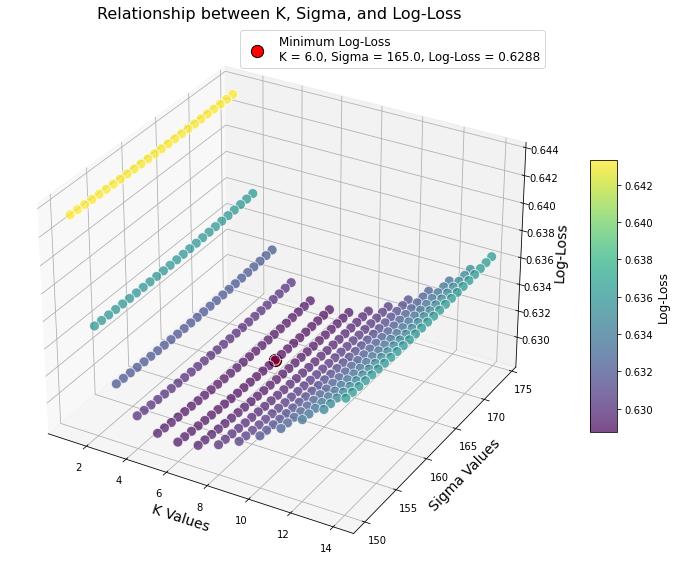

Minimum Log-Loss: 0.6288
Corresponding K: 6.0, Sigma: 165.0


In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract values for plotting
K_values = results_df['K']
sigma_values = results_df['sigma']
logloss = results_df['logloss']

# Create a 3D plot for K, sigma, and log-loss
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter plot
sc = ax.scatter(K_values, sigma_values, logloss, c=logloss, cmap='viridis', s=100, alpha=0.7, edgecolors='w')

# Set labels
ax.set_xlabel('K Values', fontsize=14)
ax.set_ylabel('Sigma Values', fontsize=14)
ax.set_zlabel('Log-Loss', fontsize=14)
ax.set_title('Relationship between K, Sigma, and Log-Loss', fontsize=16)

# Highlight the point with the minimum log-loss
min_logloss_row = results_df.loc[results_df['logloss'].idxmin()]
min_K = min_logloss_row['K']
min_sigma = min_logloss_row['sigma']
min_logloss = min_logloss_row['logloss']

ax.scatter(min_K, min_sigma, min_logloss, color='red', s=150, edgecolors='black', label=f'Minimum Log-Loss\nK = {min_K}, Sigma = {min_sigma}, Log-Loss = {min_logloss:.4f}')

# Add a color bar to represent log-loss values
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Log-Loss', fontsize=12)

# Add a legend
ax.legend(fontsize=12)

# Show grid and plot
ax.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Print the corresponding K and sigma values for the minimum log-loss
print(f'Minimum Log-Loss: {min_logloss:.4f}')
print(f'Corresponding K: {min_K}, Sigma: {min_sigma}')

## Split Dataset:

In [21]:
all_matches_k['Date'] = pd.to_datetime(all_matches_k['Date'], format='%Y-%m-%d')
split_time = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
all_matches_k_train = all_matches_k[all_matches_k['Date'] < split_time]
all_matches_k_validation = all_matches_k[all_matches_k['Date'] >= split_time]

## Evaluate Model Performance:

In [22]:
print("\033[1mOptimised K - Metrics\033[0m")

# Evaluate the model on the validation set and print the results
accuracy_k, calibration_k, log_loss_k = evaluate_mov_model(all_matches_k_validation)
print(f"Accuracy: {accuracy_k:.4f}")
print(f"Calibration: {calibration_k:.4f}")
print(f"Log Loss: {log_loss_k:.4f}")

Optimised K - Metrics
Accuracy: 0.6319
Calibration: 1.0024
Log Loss: 0.6288


## Filtering Top 50 and Top 100 Ranking players from the dataset:

In [23]:
# Load your dataset
df = all_matches_k_validation

In [24]:
# Define function to filter dataset for top N players
def filter_top_players(df, top_n):
    df_top = df[(df['WRank'] <= top_n) | (df['LRank'] <= top_n)]
    return df_top

In [25]:
# Filter the dataset for top 50 and top 100 players
df_top_50 = filter_top_players(df, 50)
df_top_100 = filter_top_players(df, 100)

## Metrics - Top 50 & Top 100:

In [26]:
print("\033[1mMetrics - Top 50\033[0m")
accuracy_50, calibration_50, log_loss_50 = evaluate_mov_model(df_top_50)
print(f"Accuracy: {accuracy_50:.4f}")
print(f"Calibration: {calibration_50:.4f}")
print(f"Log Loss: {log_loss_50:.4f}")

Metrics - Top 50
Accuracy: 0.6546
Calibration: 1.0149
Log Loss: 0.6084


In [27]:
print("\033[1mMetrics - Top 100\033[0m")
accuracy_100, calibration_100, log_loss_100 = evaluate_mov_model(df_top_100)
print(f"Accuracy: {accuracy_100:.4f}")
print(f"Calibration: {calibration_100:.4f}")
print(f"Log Loss: {log_loss_100:.4f}")

Metrics - Top 100
Accuracy: 0.6342
Calibration: 1.0092
Log Loss: 0.6273


In [28]:
# Create a DataFrame to store the validation statistics
validation_stats = pd.DataFrame({
    'Model': [
        'K_Constant_Optimised', 'K_Constant_Optimised Top 50', 'K_Constant_Optimised Top 100'
    ],
    'Accuracy': [
        accuracy_k, accuracy_50, accuracy_100
    ],
    'Log_Loss': [
        log_loss_k, log_loss_50, log_loss_100
    ],
    'Calibration': [
        calibration_k, calibration_50, calibration_100
    ]
})

# Print the validation statistics DataFrame
validation_stats

,Model,Accuracy,Log_Loss,Calibration
0,K_Constant_Optimised,0.631914,0.628766,1.002411
1,K_Constant_Optimised Top 50,0.654587,0.608388,1.014868
2,K_Constant_Optimised Top 100,0.634248,0.627267,1.009163
